## Import packages

In [1]:
# If using Google Colab, uncomment the following line
# !pip install rasterio

import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
import torch.optim as optim                             # Optimization algorithms
import torch.nn as nn                                   # Neural network modules
import os                                               # Operating system utilities
import glob                                             # File path pattern matching
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data

from datetime import datetime, timedelta                # Date/time utilities
from rasterio.plot import show                          # Plot raster data	

import deepSSF_model                                    # Import the deepSSF model
import deepSSF_utils                                    # Import the deepSSF utilities

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


### If using Google Colab, uncomment the following lines

The file directories will also need to be changed to match the location of the files in your Google Drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import data

# Importing spatial data

Instead of importing the stacks of local layers (one for each step), here we want to import the spatial covariates for the extent we want to simulate over. We use an extent that covers all of the observed locations, which refer to as the 'landscape'.

In [2]:
# select the id of that data that the model was trained on
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

# Lag the values in column 'A' by one index
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

# Importing spatial data

Instead of importing the stacks of local layers (one for each step), here we want to import the spatial covariates for the extent we want to simulate over. We use an extent that covers all of the observed locations, which refer to as the 'landscape'.

## Sentinel-2 bands

Each stack represents a month of median values of cloud-free pixels, and each layer in the stack are the bands.

During the data preparation all of these layers were scaled by 10,000, and don't need to be scaled any further.

In [4]:
# Specify the directory containing your TIFF files
data_dir = '../mapping/cropped rasters/sentinel2/25m'  # Replace with the actual path to your TIFF files

# Use glob to get a list of all TIFF files matching the pattern
tif_files = glob.glob(os.path.join(data_dir, 'S2_SR_masked_scaled_25m_*.tif'))
print(f'Found {len(tif_files)} TIFF files')
print('\n'.join(tif_files))

Found 12 TIFF files
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_01.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_02.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_03.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_04.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_05.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_06.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_07.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_08.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_09.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_10.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_11.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_12.tif


In [5]:
# Initialise a dictionary to store data with date as the key
data_dict = {}

# Loop over each TIFF file to read and process the data
for tif_file in tif_files:
    # Extract the filename from the path
    filename = os.path.basename(tif_file)
    
    # Extract the date from the filename
    # Assuming filenames are in the format 'S2_SR_masked_YYYY_MM.tif'
    date_str = filename.replace('S2_SR_masked_scaled_25m_', '').replace('.tif', '')
    # date_str will be something like '2019_01'
    
    # Read the TIFF file using rasterio
    with rasterio.open(tif_file) as src:
        # Read all bands of the TIFF file
        data = src.read()
        # 'data' is a NumPy array with shape (bands, height, width)

        # Count the number of cells that are NaN
        n_nan = np.isnan(data).sum()

        print(f"Date: {date_str}")
        print(f"Number of NaN values in {date_str}: {n_nan}")
        print(f'Proportion of NaN values: {n_nan / data.size:.4%}\n')

        # Replace NaN values with zeros	
        data = np.nan_to_num(data, nan=0)
        
        # Add the data to the dictionary with date as the key
        data_dict[date_str] = data


Date: 2019_01
Number of NaN values in 2019_01: 2460
Proportion of NaN values: 0.0037%

Date: 2019_02
Number of NaN values in 2019_02: 420
Proportion of NaN values: 0.0006%

Date: 2019_03
Number of NaN values in 2019_03: 478731
Proportion of NaN values: 0.7291%

Date: 2019_04
Number of NaN values in 2019_04: 13296
Proportion of NaN values: 0.0202%

Date: 2019_05
Number of NaN values in 2019_05: 144
Proportion of NaN values: 0.0002%

Date: 2019_06
Number of NaN values in 2019_06: 144
Proportion of NaN values: 0.0002%

Date: 2019_07
Number of NaN values in 2019_07: 96
Proportion of NaN values: 0.0001%

Date: 2019_08
Number of NaN values in 2019_08: 144
Proportion of NaN values: 0.0002%

Date: 2019_09
Number of NaN values in 2019_09: 36
Proportion of NaN values: 0.0001%

Date: 2019_10
Number of NaN values in 2019_10: 0
Proportion of NaN values: 0.0000%

Date: 2019_11
Number of NaN values in 2019_11: 48
Proportion of NaN values: 0.0001%

Date: 2019_12
Number of NaN values in 2019_12: 0
Prop

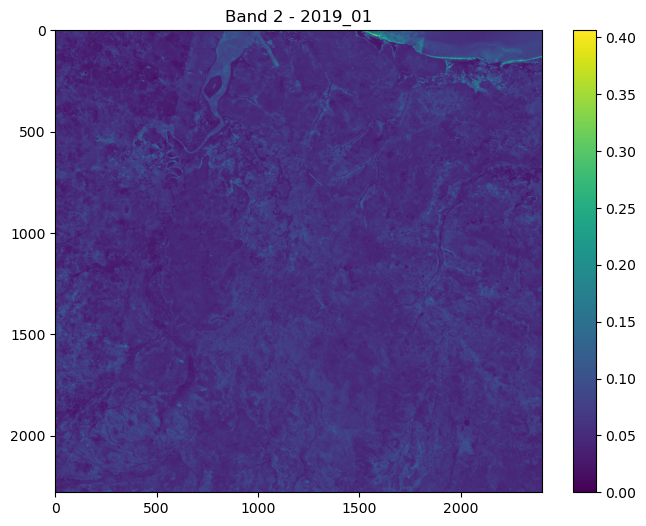

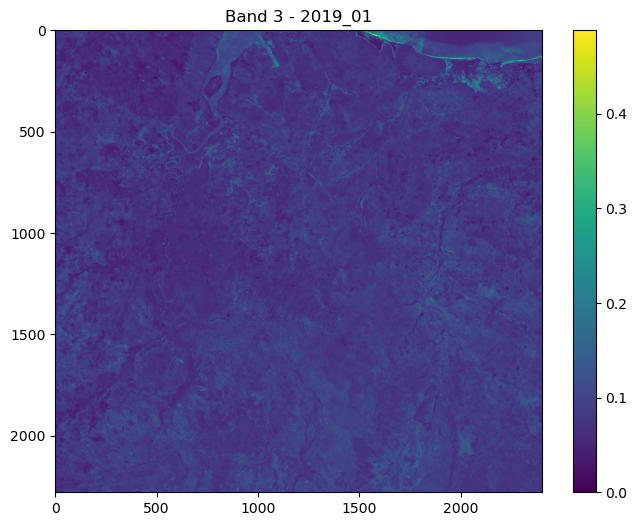

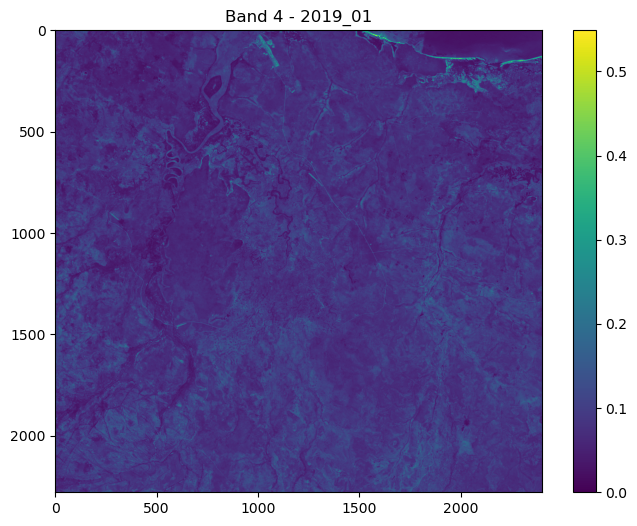

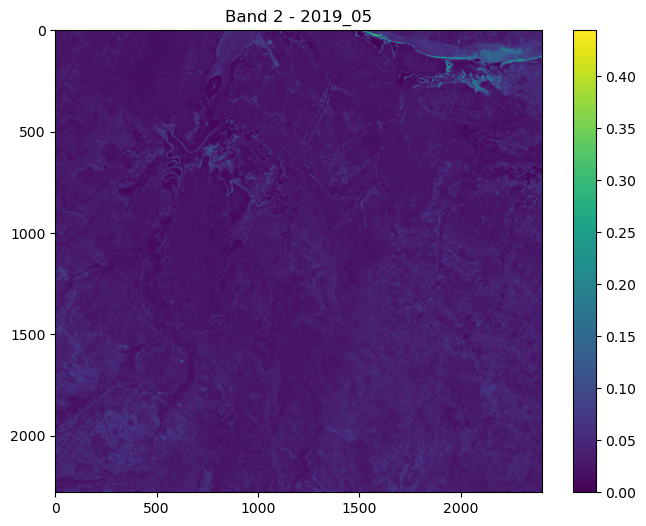

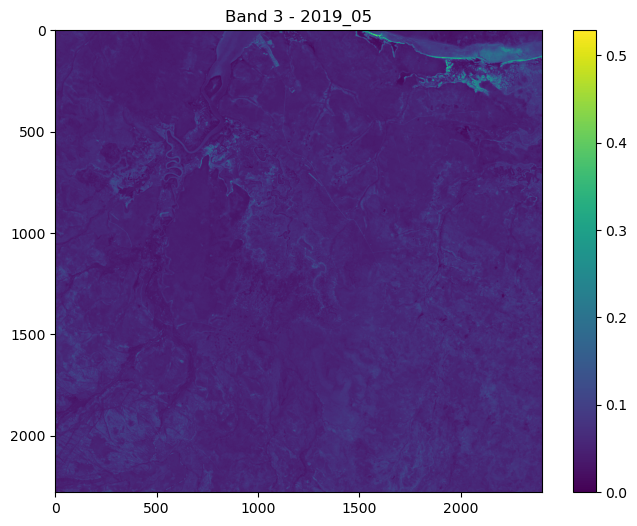

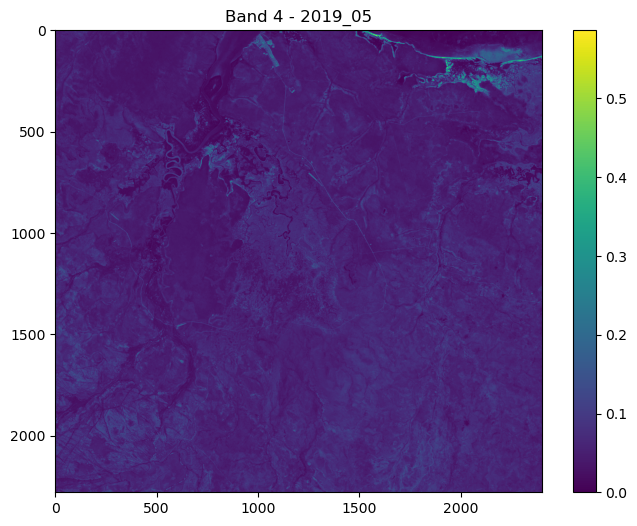

In [6]:
# Select some bands from the processed data stored in 'data_dict' for plotting
layers_to_plot = []

# Specify the date and band numbers you want to plot
dates_to_plot = ['2019_01', '2019_05']  # This grabs all available dates. You can select specific ones if needed.
bands_to_plot = [1, 2, 3]  # Band indices for bands 2, 3, and 4, which are B, G, and R

# Loop through the selected dates and bands to prepare them for plotting
for date_str in dates_to_plot:
    data = data_dict[date_str]  # Get the normalized data for this date
    
    for band_idx in bands_to_plot:
        # Collect the specific band for plotting
        layers_to_plot.append((data[band_idx], band_idx + 1, date_str))

# Plot the stored layers
for band, band_number, date_str in layers_to_plot:
    plt.figure(figsize=(8, 6))
    plt.imshow(band, cmap='viridis') 
    plt.title(f'Band {band_number} - {date_str}')
    plt.colorbar() #label='Normalized Value'
    plt.show()


### Plot as RGB

We can also visualise the Sentinel-2 bands as an RGB image, using the Red, Green and Blue bands.

The plotting was a bit dark so we will adjust the brightness of the image using a gamma correction.

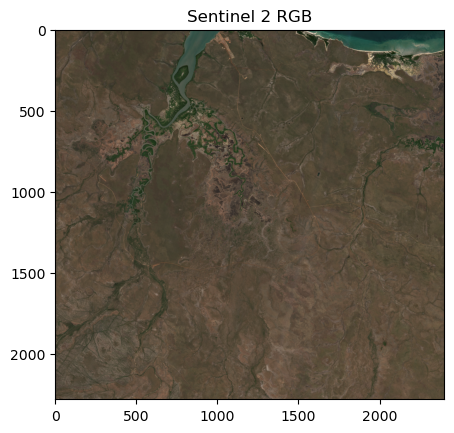

In [7]:
# Specify the date for the RGB layers
date_str = '2019_08'  

# pull out the RGB bands
r_band = data_dict[date_str][3]
g_band = data_dict[date_str][2]
b_band = data_dict[date_str][1]

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Apply gamma correction to the image
gamma = 1.75
rgb_image = rgb_image ** (1/gamma)

plt.figure()  # Create a new figure
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.show()
plt.close()  # Close the figure to free memory

## Slope

In [8]:
# Path to the slope raster file
file_path = '../mapping/cropped rasters/slope.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_landscape = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    raster_transform = src.transform # same as the raster transform in the NDVI raster read

Slope metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of slope landscape raster:
(2280, 2400)


Number of NA values in the slope raster:
9356


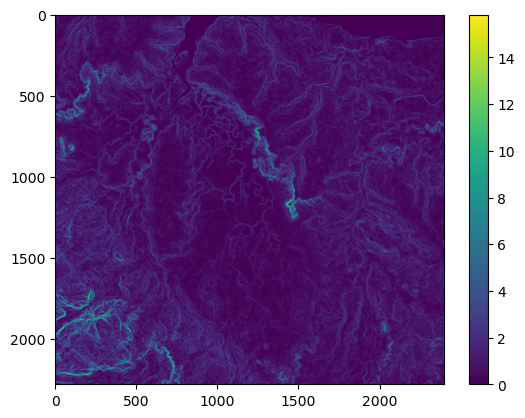

In [9]:
# Check the slope metadata:
print("Slope metadata:")
print(slope_meta)
print("\n")

# Check the shape (rows, columns) of the slope landscape raster:
print("Shape of slope landscape raster:")
print(slope_landscape.shape)
print("\n")

# Check for NA values in the slope raster:
print("Number of NA values in the slope raster:")
print(np.isnan(slope_landscape).sum())

# Replace NaNs in the slope array with 0.0 (representing water):
slope_landscape = np.nan_to_num(slope_landscape, nan=0.0)

# Define the maximum and minimum slope values from the stack of local layers:
slope_max = 12.2981
slope_min = 0.0006

# Convert the slope landscape data from a NumPy array to a PyTorch tensor:
slope_landscape_tens = torch.from_numpy(slope_landscape)

# Normalize the slope landscape data:
slope_landscape_norm = (slope_landscape_tens - slope_min) / (slope_max - slope_min)

# Visualize the slope landscape (note: displaying the original tensor, not the normalised data):
plt.imshow(slope_landscape_tens.numpy())
plt.colorbar()
plt.show()


### Convert between numpy array and raster

To check that we can go back and forth between numpy arrays (with pixel coordinates) and rasters (with geographic coordinates), we will convert the slope numpy array to a raster. 

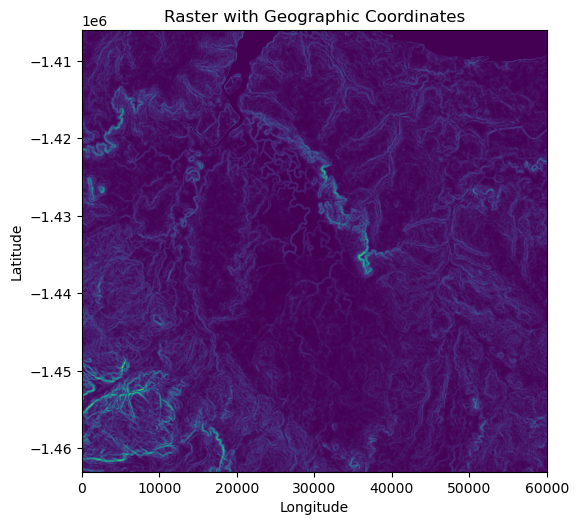

In [10]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

# Convert the slope_landcape (numpy array) to a raster and plot with the rasterio library
rasterio.plot.show(slope_landscape, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

## Subset function

As we described the subset function in the `deepSSF_simulations.ipynb` notebook, and stored it in the `deepSSF_functions.py` script, we will just import it here.

In [23]:
subset_function = deepSSF_utils.subset_raster_with_padding_torch

### Testing the subset function

We want to ensure that the function pads the raster when it is outside the landscape extent.

torch.Size([12, 2280, 2400])


Text(0.5, 1.0, 'Slope Subset')

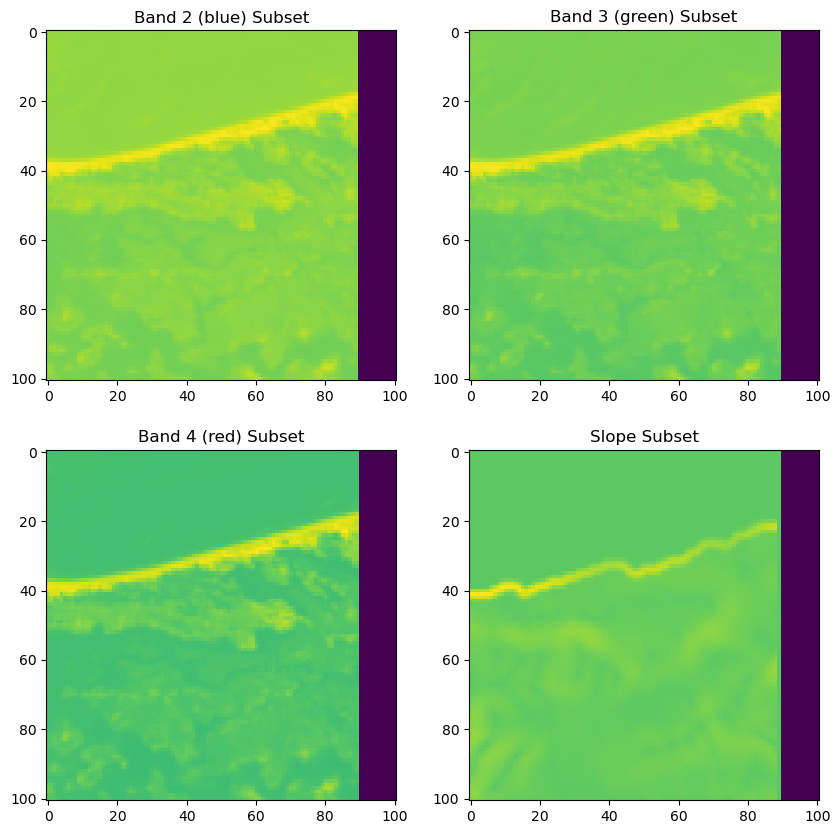

In [24]:
x = 5.9e4
y = -1.41e6
window_size = 101

# Get the subset of the slope landscape
slope_subset, origin_x, origin_y = subset_function(slope_landscape_norm, x, y, window_size, raster_transform)

# For sentinel 2 data
selected_month = '2019_01'
# Get the data for the selected month
s2_data = data_dict[selected_month]

# Convert the NumPy array to a PyTorch tensor
s2_tensor = torch.from_numpy(s2_data)
s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
print(s2_tensor.shape) # [bands, height, width]

# Get the subset of the Sentinel-2 bands
s2_b1_subset, origin_x, origin_y = subset_function(s2_tensor[0,:,:], x, y, window_size, raster_transform)
s2_b2_subset, origin_x, origin_y = subset_function(s2_tensor[1,:,:], x, y, window_size, raster_transform)
s2_b3_subset, origin_x, origin_y = subset_function(s2_tensor[2,:,:], x, y, window_size, raster_transform)
s2_b4_subset, origin_x, origin_y = subset_function(s2_tensor[3,:,:], x, y, window_size, raster_transform)
s2_b5_subset, origin_x, origin_y = subset_function(s2_tensor[4,:,:], x, y, window_size, raster_transform)
s2_b6_subset, origin_x, origin_y = subset_function(s2_tensor[5,:,:], x, y, window_size, raster_transform)
s2_b7_subset, origin_x, origin_y = subset_function(s2_tensor[6,:,:], x, y, window_size, raster_transform)
s2_b8_subset, origin_x, origin_y = subset_function(s2_tensor[7,:,:], x, y, window_size, raster_transform)
s2_b8a_subset, origin_x, origin_y = subset_function(s2_tensor[8,:,:], x, y, window_size, raster_transform)
s2_b9_subset, origin_x, origin_y = subset_function(s2_tensor[9,:,:], x, y, window_size, raster_transform)
s2_b11_subset, origin_x, origin_y = subset_function(s2_tensor[10,:,:], x, y, window_size, raster_transform)
s2_b12_subset, origin_x, origin_y = subset_function(s2_tensor[11,:,:], x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(s2_b2_subset.detach().numpy(), cmap='viridis')
axs[0, 0].set_title('Band 2 (blue) Subset')

axs[0, 1].imshow(s2_b3_subset.detach().numpy(), cmap='viridis')
axs[0, 1].set_title('Band 3 (green) Subset')

axs[1, 0].imshow(s2_b4_subset.detach().numpy(), cmap='viridis')
axs[1, 0].set_title('Band 4 (red) Subset')

axs[1, 1].imshow(slope_subset.detach().numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')


# Load the model

## Set the device for the model

In [14]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. 
These are the values that will be used to instantiate the model.

In [15]:
# In our case the 12 Sentinel-2 layers + slope
num_spatial_covs = 13 

params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": num_spatial_covs + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [16]:
params = deepSSF_model.ModelParams(params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128,

## Load the model weights

In [17]:
# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/deepSSF_S2_slope_buffalo2005_2025-02-09.pt', 
                                 map_location=torch.device('cpu'),
                                 weights_only=True))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

# Setup validation

To get the validation running we need a few extra functions. 

Firstly, we need to index the Sentinel-2 layers correctly, based on the time of the simulated location. We'll do this by creating a function that takes day of the year of the simulated location and returns the correct index for the Sentinel-2 layers.

This indexing is slightly different from the indexing we used for the `deepSSF_simulations.ipynb` notebook, which was indexing NDVI layers. In that case we were indexing the layers directly, and therefore the first entry was at 0 (i.e., March was in month_index = 2). Here, we are creating a string that corresponds to the layer name, and therefore the first entry is at 1. (i.e., March will be at month_index = 3)

In [18]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2019, 1, 1)
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    month_index = (date.month) + (year_diff * 12)  # month index (1-based)
    if month_index == 0:
        month_index += 1
    return month_index

yday = 35
month_index = day_to_month_index(yday)
print(month_index)

2


### Check the Sentinel-2 layer indexing

Subset the raster layers at the first observed location of the training data.

Starting x and y coordinates: 43036.55199338104, -1437242.6615283354
Starting day of the year:     271
torch.Size([12, 2280, 2400])


Text(0.5, 1.0, 'Slope Subset')

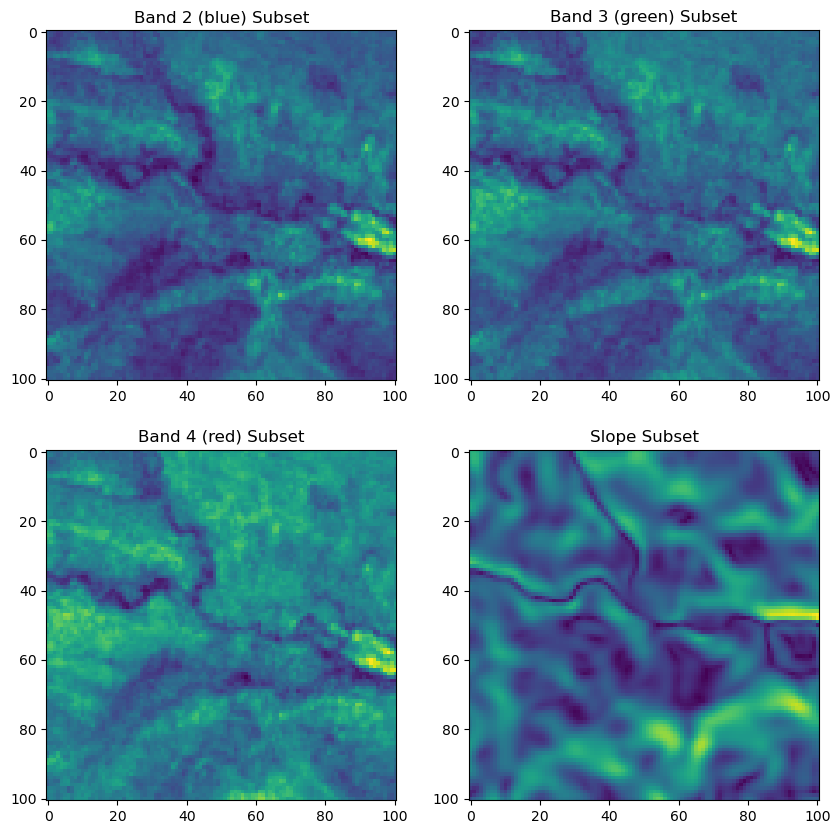

In [25]:
# Set the window size for the local layers 
# (should be the same as the one used during training)
window_size = 101

# Step index for the buffalo data
step_index = 1503

# starting location of buffalo 2005
x = buffalo_df['x1_'].iloc[step_index]
y = buffalo_df['y1_'].iloc[step_index]
print(f'Starting x and y coordinates: {x}, {y}')

yday = buffalo_df['yday_t2'].iloc[step_index]
print(f'Starting day of the year:     {yday}')

# Get the month index from the day of the year
month_index = day_to_month_index(yday)

# for sentinel 2 data
selected_month = f'2019_{month_index:02d}'
# Get the normalized data for the selected month
s2_data = data_dict[selected_month]

# Convert the NumPy array to a PyTorch tensor
s2_tensor = torch.from_numpy(s2_data)
s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
print(s2_tensor.shape)

# Get the subset of the Sentinel-2 bands
s2_b1_subset, origin_x, origin_y = subset_function(s2_tensor[0,:,:], x, y, window_size, raster_transform)
s2_b2_subset, origin_x, origin_y = subset_function(s2_tensor[1,:,:], x, y, window_size, raster_transform)
s2_b3_subset, origin_x, origin_y = subset_function(s2_tensor[2,:,:], x, y, window_size, raster_transform)
s2_b4_subset, origin_x, origin_y = subset_function(s2_tensor[3,:,:], x, y, window_size, raster_transform)
s2_b5_subset, origin_x, origin_y = subset_function(s2_tensor[4,:,:], x, y, window_size, raster_transform)
s2_b6_subset, origin_x, origin_y = subset_function(s2_tensor[5,:,:], x, y, window_size, raster_transform)
s2_b7_subset, origin_x, origin_y = subset_function(s2_tensor[6,:,:], x, y, window_size, raster_transform)
s2_b8_subset, origin_x, origin_y = subset_function(s2_tensor[7,:,:], x, y, window_size, raster_transform)
s2_b8a_subset, origin_x, origin_y = subset_function(s2_tensor[8,:,:], x, y, window_size, raster_transform)
s2_b9_subset, origin_x, origin_y = subset_function(s2_tensor[9,:,:], x, y, window_size, raster_transform)
s2_b11_subset, origin_x, origin_y = subset_function(s2_tensor[10,:,:], x, y, window_size, raster_transform)
s2_b12_subset, origin_x, origin_y = subset_function(s2_tensor[11,:,:], x, y, window_size, raster_transform)

# Get the subset of the slope landscape
slope_subset, origin_x, origin_y = subset_function(slope_landscape_norm, x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(s2_b2_subset.numpy(), cmap='viridis')
axs[0, 0].set_title('Band 2 (blue) Subset')

axs[0, 1].imshow(s2_b3_subset.numpy(), cmap='viridis')
axs[0, 1].set_title('Band 3 (green) Subset')

axs[1, 0].imshow(s2_b4_subset.numpy(), cmap='viridis')
axs[1, 0].set_title('Band 4 (red) Subset')

axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')

### Plot as RGB

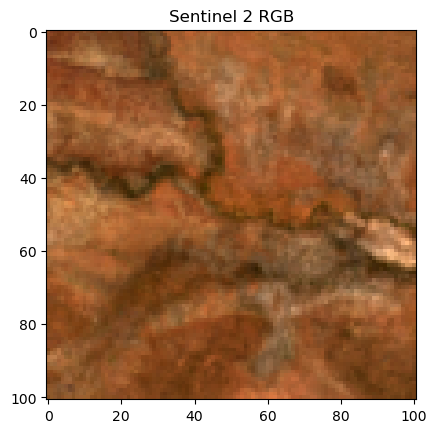

In [26]:
# pull out the RGB bands
r_band = s2_b4_subset.detach().numpy()
g_band = s2_b3_subset.detach().numpy()
b_band = s2_b2_subset.detach().numpy()

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure()  # Create a new figure
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.show()
plt.close()  # Close the figure to free memory

## Create a mask for edge cells

Due to the padding at the edges of the covariates, convolutional layers create artifacts that can affect the colour scale of the predictions when plotting. To avoid this, we will create a mask that we can apply to the predictions to remove the edge cells.

In [21]:
# Create a mask to remove the edge values for plotting 
# (as it affects the colour scale)
x_mask = np.ones_like(slope_subset)
y_mask = np.ones_like(slope_subset)

# Mask out bordering cells
x_mask[:, :3] = -np.inf
x_mask[:, 98:] = -np.inf
y_mask[:3, :] = -np.inf
y_mask[98:, :] = -np.inf

# Next-step probability values

We can now calculate the next-step probabilities for each observed step. As we generate habitat selection, movement and next-step probability surfaces, we can get the predicted probability values for each one, which can be compared to the respective process in the SSF.

The process for generating the next-step probabilities is as follows:

1. Get the current location of the individual
2. Crop out the local layers for the current location
3. Run the model of the local layers to get the habitat selection, movement and next-step probability surfaces
4. Get the predicted probability values at the location of the next step
5. Store the predicted probability values and export them as a csv for comparison with the SSF

First, select the data to generate prediction values for. For testing the function we can select a subset.

In [29]:
# To select a subset of samples to test the function
# test_data = buffalo_df.iloc[0:10]

# To select all of the data
test_data = buffalo_df

# Get the number of samples in the test data
n_samples = len(test_data)
print(f'Number of samples: {n_samples}')

# Create empty vectors to store the predicted probabilities
habitat_probs = np.repeat(0., n_samples)
move_probs = np.repeat(0., n_samples)
next_step_probs = np.repeat(0., n_samples)


Number of samples: 10103


### Directory for saving next-step prediction plots

In [30]:
# output directory for saving probability values
output_dir = f'../outputs/next_step_validation/S2/id{buffalo_id}'
os.makedirs(output_dir, exist_ok=True)

## Loop over each step

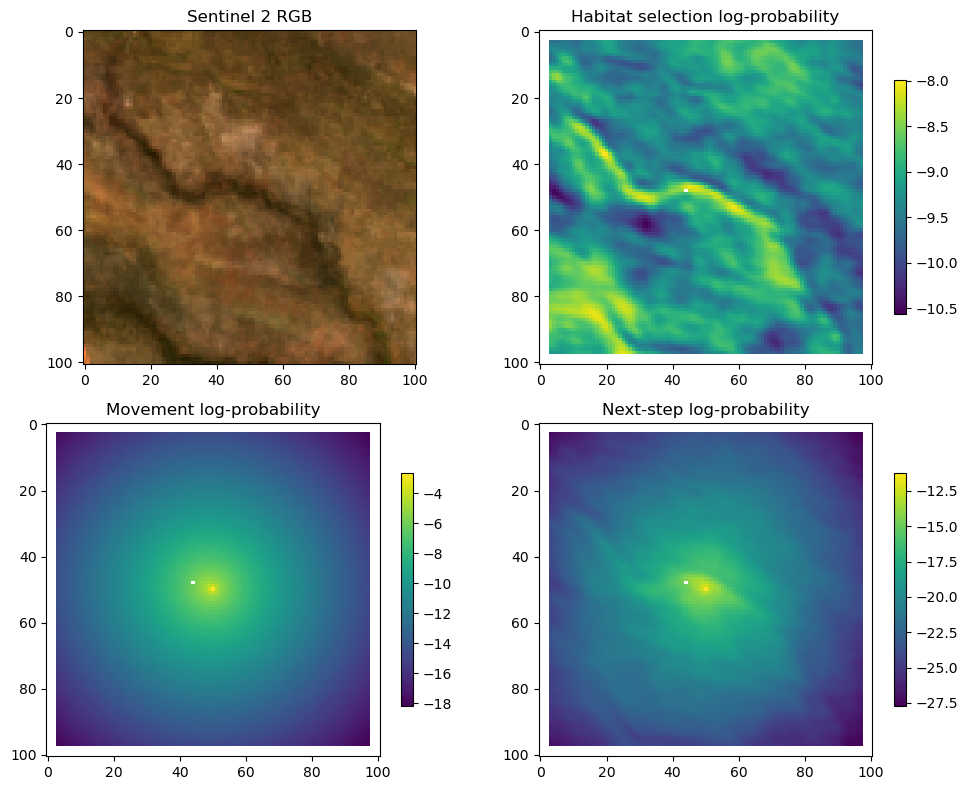

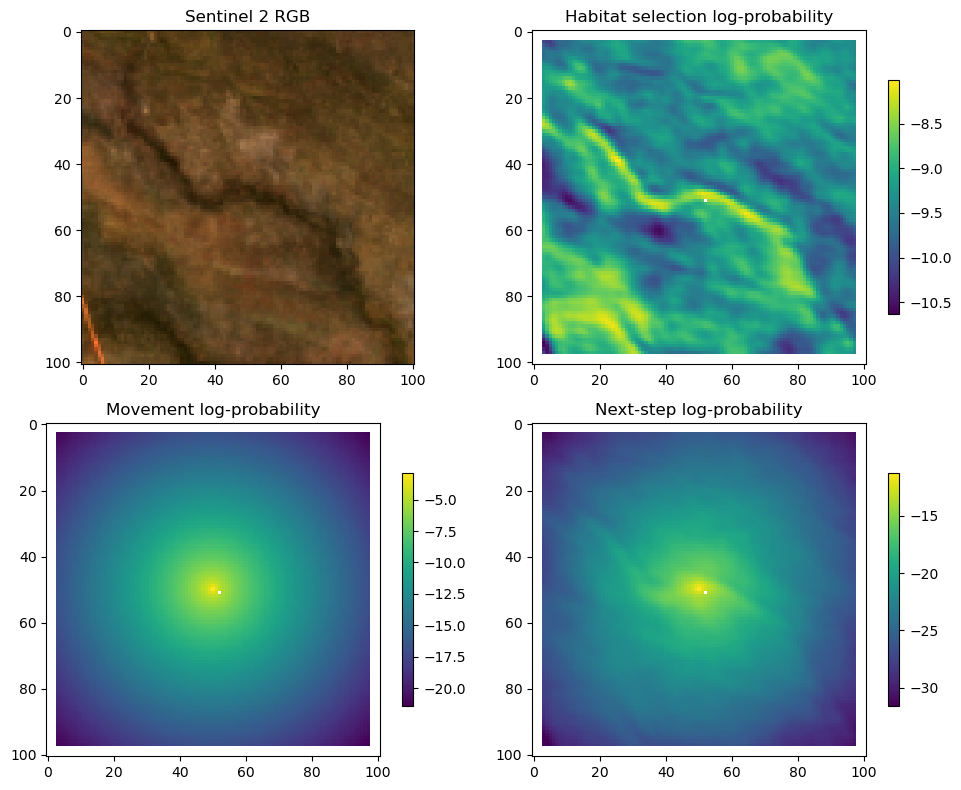

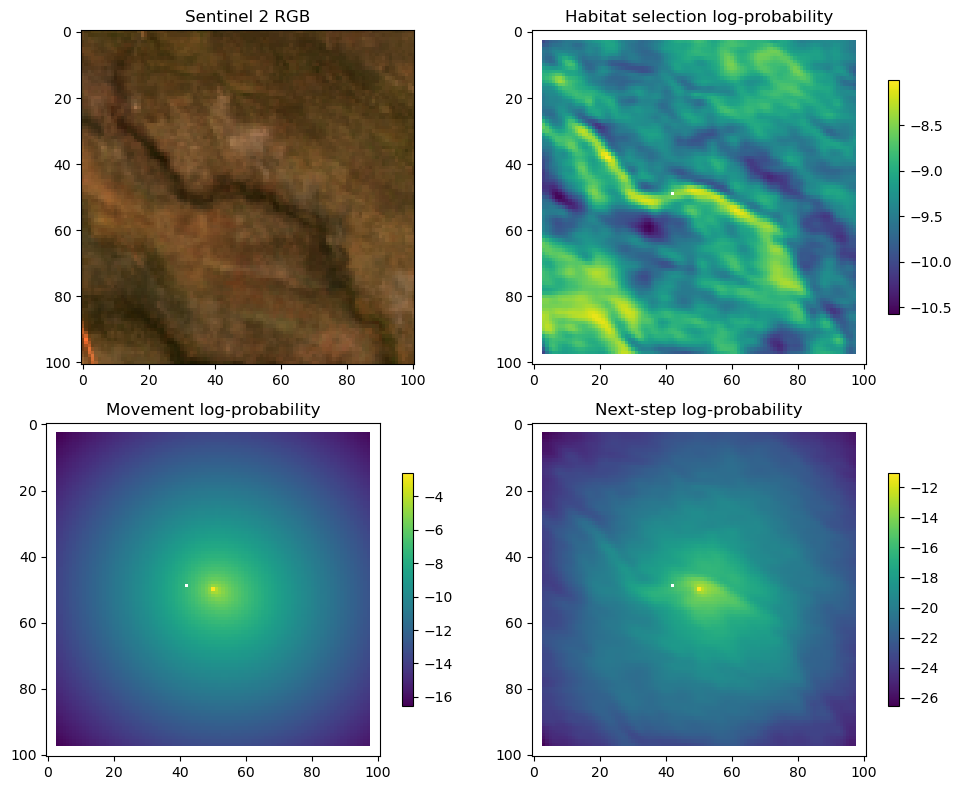

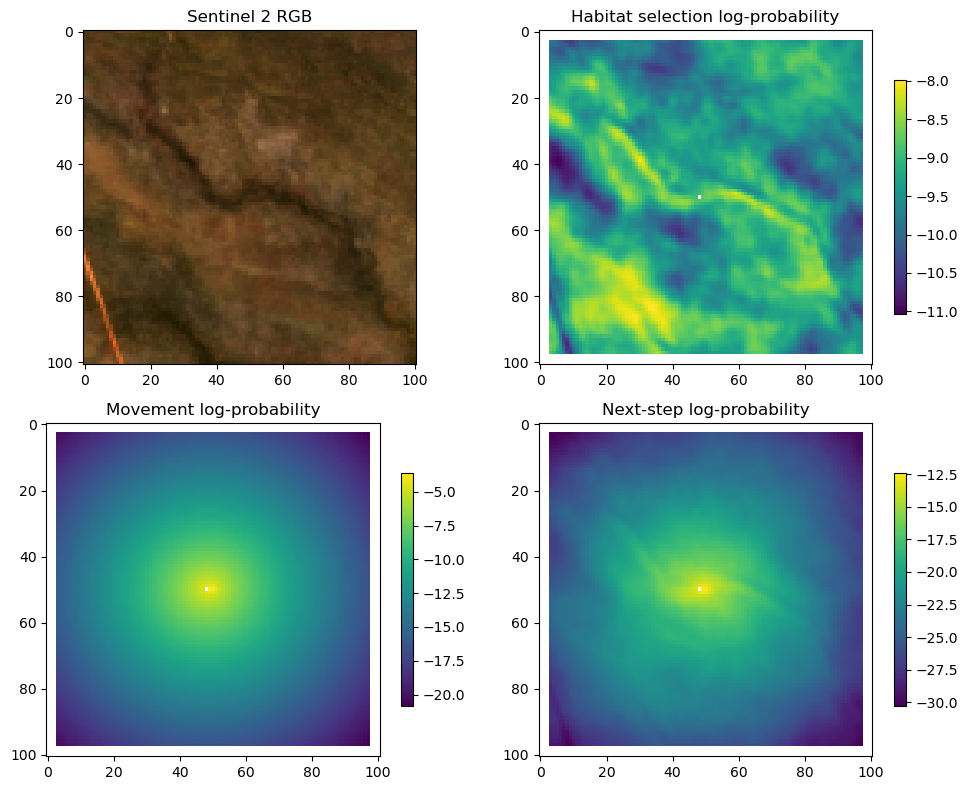

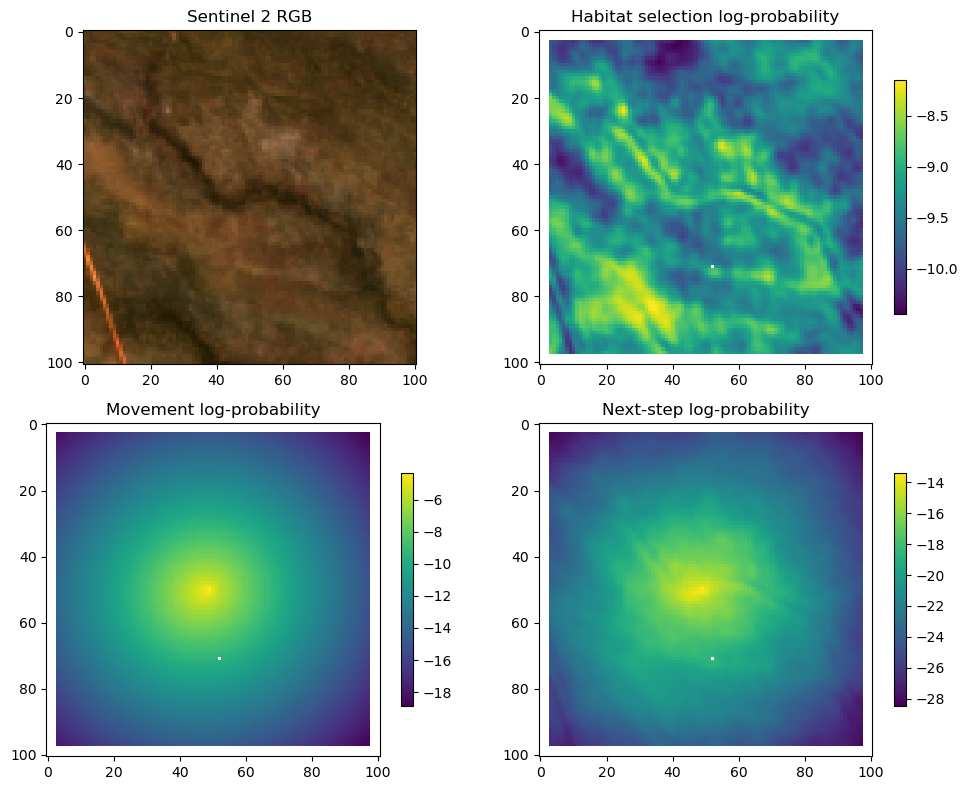

In [32]:
# Start at 1 so the bearing at t - 1 is available
for i in range(1, n_samples):
  
  sample = test_data.iloc[i]

  # Current location (x1, y1)
  x = sample['x1_']
  y = sample['y1_']

  # Convert geographic coordinates to pixel coordinates
  px, py = ~raster_transform * (x, y)

  # Next step location (x2, y2)
  x2 = sample['x2_']
  y2 = sample['y2_']

  # Convert geographic coordinates to pixel coordinates
  px2, py2 = ~raster_transform * (x2, y2)

  # The difference in x and y coordinates
  d_x = x2 - x
  d_y = y2 - y
  # print('d_x and d_y are ', d_x, d_y) # Debugging
  
  # Temporal covariates
  hour_t2_sin = sample['hour_t2_sin']
  hour_t2_cos = sample['hour_t2_cos']
  yday_t2_sin = sample['yday_t2_sin']
  yday_t2_cos = sample['yday_t2_cos']

  # Bearing of previous step (t - 1)
  bearing = sample['bearing_tm1']

  # Hour of the day (for saving the plot)
  hour_t2 = sample['hour_t2']

  # Day of the year
  yday = sample['yday_t2']

  # Convert day of the year to month index
  month_index = day_to_month_index(yday)
  # print(month_index)

  # For sentinel 2 data
  selected_month = f'2019_{month_index:02d}'
  # Get the Sentinel-2 layers for the selected month
  s2_data = data_dict[selected_month]

  # Convert the Sentinel-2 data from a NumPy array to a PyTorch tensor
  s2_tensor = torch.from_numpy(s2_data)
  s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
  # print(s2_tensor.shape)

  # Crop out the Sentinel-2 subsets at the location of x1, y1
  s2_b1_subset, origin_x, origin_y = subset_function(s2_tensor[0,:,:], x, y, window_size, raster_transform)
  s2_b2_subset, origin_x, origin_y = subset_function(s2_tensor[1,:,:], x, y, window_size, raster_transform)
  s2_b3_subset, origin_x, origin_y = subset_function(s2_tensor[2,:,:], x, y, window_size, raster_transform)
  s2_b4_subset, origin_x, origin_y = subset_function(s2_tensor[3,:,:], x, y, window_size, raster_transform)
  s2_b5_subset, origin_x, origin_y = subset_function(s2_tensor[4,:,:], x, y, window_size, raster_transform)
  s2_b6_subset, origin_x, origin_y = subset_function(s2_tensor[5,:,:], x, y, window_size, raster_transform)
  s2_b7_subset, origin_x, origin_y = subset_function(s2_tensor[6,:,:], x, y, window_size, raster_transform)
  s2_b8_subset, origin_x, origin_y = subset_function(s2_tensor[7,:,:], x, y, window_size, raster_transform)
  s2_b8a_subset, origin_x, origin_y = subset_function(s2_tensor[8,:,:], x, y, window_size, raster_transform)
  s2_b9_subset, origin_x, origin_y = subset_function(s2_tensor[9,:,:], x, y, window_size, raster_transform)
  s2_b11_subset, origin_x, origin_y = subset_function(s2_tensor[10,:,:], x, y, window_size, raster_transform)
  s2_b12_subset, origin_x, origin_y = subset_function(s2_tensor[11,:,:], x, y, window_size, raster_transform)

  # Crop out the slope subset at the location of x1, y1
  slope_subset, origin_x, origin_y = subset_function(slope_landscape_norm, x, y, window_size, raster_transform)

  # Location of the next step in local pixel coordinates
  px2_subset = px2 - origin_x
  py2_subset = py2 - origin_y
  # print('px2_subset and py2_subset are ', px2_subset, py2_subset) # Debugging

  # Stack the channels along a new axis
  x1 = torch.stack([s2_b1_subset,
                    s2_b2_subset, 
                    s2_b3_subset, 
                    s2_b4_subset, 
                    s2_b5_subset,
                    s2_b6_subset,
                    s2_b7_subset,
                    s2_b8_subset,
                    s2_b8a_subset,
                    s2_b9_subset,
                    s2_b11_subset,
                    s2_b12_subset,
                    slope_subset], dim=0)
  
  # Add a batch dimension (required to be the correct dimension for the model)
  x1 = x1.unsqueeze(0)
  # print(x1.shape)

  # Convert lists to PyTorch tensors
  hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
  hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
  yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
  yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()

  # Stack tensors 
  x2 = torch.stack((hour_t2_sin_tensor.unsqueeze(0), 
                    hour_t2_cos_tensor.unsqueeze(0), 
                    yday_t2_sin_tensor.unsqueeze(0), 
                    yday_t2_cos_tensor.unsqueeze(0)),  
                    dim=1)
  # print(x2)
  # print(x2.shape)

  # put bearing in the correct dimension (batch_size, 1)
  bearing = torch.tensor(bearing).float().unsqueeze(0).unsqueeze(0)
  # print(bearing)
  # print(bearing.shape)

  # -------------------------------------------------------------------------
  # Run the model
  # -------------------------------------------------------------------------
  model_output = model((x1, x2, bearing))


  # -------------------------------------------------------------------------
  # Habitat selection probability
  # -------------------------------------------------------------------------
  hab_density = model_output.detach().cpu().numpy()[0,:,:,0]
  hab_density_exp = np.exp(hab_density)
  # print(np.sum(hab_density_exp)) # Should be 1

  # Store the probability of habitat selection at the location of x2, y2
  # These probabilities are normalised in the model function
  habitat_probs[i] = hab_density_exp[(int(py2_subset), int(px2_subset))]
  # print('Habitat probability value = ', habitat_probs[i])


  # -------------------------------------------------------------------------
  # Movement probability
  # -------------------------------------------------------------------------
  move_density = model_output.detach().cpu().numpy()[0,:,:,1]
  move_density_exp = np.exp(move_density)
  # print(np.sum(move_density_exp))  # Should be 1

  # Store the movement probability at the location of x2, y2
  # These probabilities are normalised in the model function
  move_probs[i] = move_density_exp[(int(py2_subset), int(px2_subset))]
  # print('Movement probability value = ', move_probs[i])


  # -------------------------------------------------------------------------
  # Next step probability
  # -------------------------------------------------------------------------
  step_density = hab_density + move_density
  step_density_exp = np.exp(step_density)
  # print('Sum of step density exp = ', np.sum(step_density_exp)) # Won't be 1

  step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
  # print('Sum of step density exp norm = ', np.sum(step_density_exp_norm)) # Should be 1

  # Extract the value of the covariates at the location of x2, y2
  next_step_probs[i] = step_density_exp_norm[(int(py2_subset), int(px2_subset))]
  # print('Next-step probability value = ', next_step_probs[i])


  # -------------------------------------------------------------------------
  # Plot the next-step predictions
  # -------------------------------------------------------------------------

  # Plot the first few probability surfaces - change the condition to i < n_steps to plot all
  if i < 6:

    # Mask out bordering cells
    hab_density_mask = hab_density * x_mask * y_mask
    move_density_mask = move_density * x_mask * y_mask
    step_density_mask = step_density * x_mask * y_mask

    # Create a mask for the next step
    next_step_mask = np.ones_like(hab_density)
    next_step_mask[int(py2_subset), int(px2_subset)] = -np.inf

    # Plot the outputs
    fig_out, axs_out = plt.subplots(2, 2, figsize=(10, 8))

    # RGB for plotting
    # pull out the RGB bands
    r_band = s2_b4_subset.detach().numpy()
    g_band = s2_b3_subset.detach().numpy()
    b_band = s2_b2_subset.detach().numpy()

    # Stack the bands along a new axis
    rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
    # Normalize to the range [0, 1] for display
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Plot s2_b2
    im1 = axs_out[0, 0].imshow(rgb_image)
    axs_out[0, 0].set_title('Sentinel 2 RGB')

    # Plot habitat selection log-probability
    im2 = axs_out[0, 1].imshow(hab_density_mask * next_step_mask, cmap='viridis')
    axs_out[0, 1].set_title('Habitat selection log-probability')
    fig_out.colorbar(im2, ax=axs_out[0, 1], shrink=0.7)

    # Movement density log-probability
    im3 = axs_out[1, 0].imshow(move_density_mask * next_step_mask, cmap='viridis')
    axs_out[1, 0].set_title('Movement log-probability')
    fig_out.colorbar(im3, ax=axs_out[1, 0], shrink=0.7)

    # Next-step probability
    im4 = axs_out[1, 1].imshow(step_density_mask * next_step_mask, cmap='viridis')
    axs_out[1, 1].set_title('Next-step log-probability')
    fig_out.colorbar(im4, ax=axs_out[1, 1], shrink=0.7)

    filename_covs = f'{output_dir}/id{buffalo_id}_step{i+1}_yday{yday}_hour{hour_t2}.png'
    plt.tight_layout()
    plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory

In [33]:
print(next_step_probs)

[0.         0.00339567 0.01028473 ... 0.00365443 0.00018823 0.00017365]


## Calculate the null probabilities

As each cell has a probability values, we can calculate what the probability would be if the model provided no information at all, and each cell was equally likely to be the next step. This is just 1 divided by the total number of cells.

In [34]:
null_prob = 1 / (window_size ** 2)
print(f'Null probability: {null_prob:.3e}')

Null probability: 9.803e-05


## Compute the rolling average of the probabilities

In [35]:
rolling_window_size = 100 # Rolling window size

# Convert to pandas Series and compute rolling mean
rolling_mean_habitat = pd.Series(habitat_probs).rolling(window=window_size, center=True).mean()
rolling_mean_movement = pd.Series(move_probs).rolling(window=window_size, center=True).mean()
rolling_mean_next_step = pd.Series(next_step_probs).rolling(window=window_size, center=True).mean()

# Plot the probabilities

We can get an idea of how variable the probabilities are for the habitat selection and movement surfaces, and for the next-step probabilities, by plotting them across the trajectory

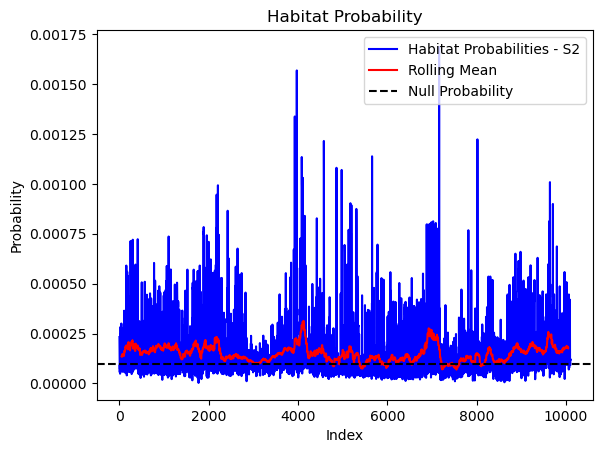

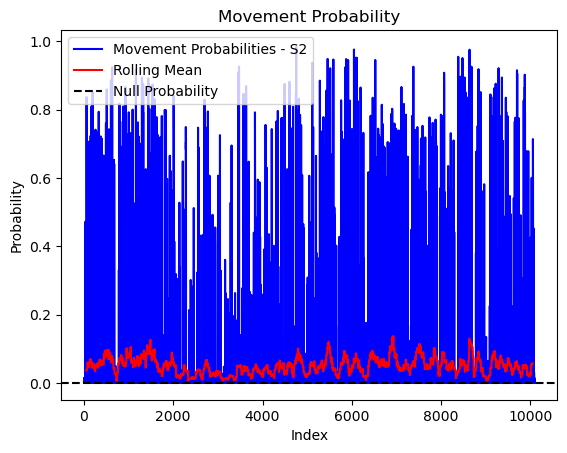

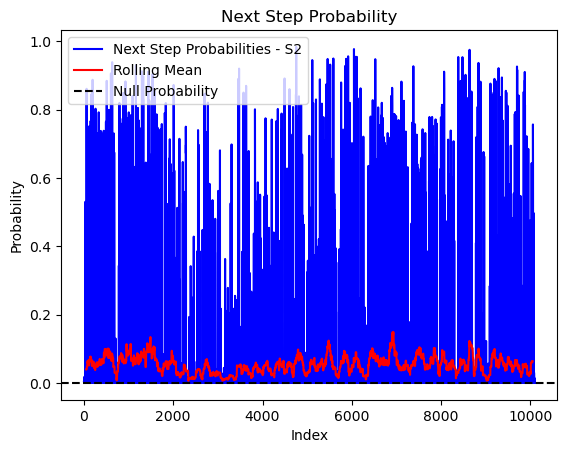

In [36]:
# Plot the habitat probs through time as a line graph
plt.plot(habitat_probs[habitat_probs > 0], color='blue', label='Habitat Probabilities - S2')
plt.plot(rolling_mean_habitat[rolling_mean_habitat > 0], color='red', label='Rolling Mean')
plt.axhline(y=null_prob, color='black', linestyle='--', label='Null Probability')  # null probs
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Habitat Probability')
plt.legend()  # Add legend to differentiate lines
plt.show()

# Plot the movement probs through time as a line graph
plt.plot(move_probs[move_probs > 0], color='blue', label='Movement Probabilities - S2')
plt.plot(rolling_mean_movement[rolling_mean_movement > 0], color='red', label='Rolling Mean')
plt.axhline(y=null_prob, color='black', linestyle='--', label='Null Probability')  # null probs
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Movement Probability')
plt.legend()  # Add legend to differentiate lines
plt.show()

# Plot the next step probs through time as a line graph
plt.plot(next_step_probs[next_step_probs > 0], color='blue', label='Next Step Probabilities - S2')
plt.plot(rolling_mean_next_step[rolling_mean_next_step > 0], color='red', label='Rolling Mean')
plt.axhline(y=null_prob, color='black', linestyle='--', label='Null Probability')  # null probs
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Next Step Probability')
plt.legend()  # Add legend to differentiate lines
plt.show()

# Save the probabilities

We can save the probabilities to a csv file to compare with the SSF probabilities.

In [37]:
# output directory for saving probability values
output_dir = f'../outputs/next_step_validation/S2'
os.makedirs(output_dir, exist_ok=True)

# Append the probabilities to the dataframe
buffalo_df['habitat_probs'] = habitat_probs
buffalo_df['move_probs'] = move_probs
buffalo_df['next_step_probs'] = next_step_probs

csv_filename = f'{output_dir}/deepSSF_id{buffalo_id}_n{len(test_data)}_{today_date}.csv'
print(csv_filename)
buffalo_df.to_csv(csv_filename, index=True)

../outputs/next_step_validation/S2/deepSSF_id2005_n10103_2025-02-13.csv


# Calculate probability values for other individuals

Here we want to take the model that we fitted to the focal individual, and see how well it can predict the steps of other individuals, which are in quite different areas of the landscape and occupy different environmental spaces.

We follow exactly the same process as above (but with the different locations). We are still trying the predict the next step of the individual, but they are different trajectories.

We consider this an out-of-sample test of the model.

## Load dataframes for each individual

As a check that the function is giving us what we expect we also load in the focal individual's data and calculate the probabilities for that individual (which should give exactly the same values as above).

In [ ]:
# Step 1: Specify the directory containing your TIFF files
data_dir = '../buffalo_local_data_id/'  # Replace with the actual path to your TIFF files

# Step 2: Use glob to get a list of all TIFF files matching the pattern
csv_files = glob.glob(os.path.join(data_dir, 'buffalo_*.csv')) 
print(f'Found {len(csv_files)} CSV files')
print('\n'.join(csv_files))

# select only 2005
csv_files = csv_files
# csv_files = [csv_files[0]] # to select a single id
# print(csv_files)

Found 13 CSV files
../buffalo_local_data_id/validation\validation_buffalo_2005_data_df_lag_1hr_n10297.csv
../buffalo_local_data_id/validation\validation_buffalo_2014_data_df_lag_1hr_n6572.csv
../buffalo_local_data_id/validation\validation_buffalo_2018_data_df_lag_1hr_n9440.csv
../buffalo_local_data_id/validation\validation_buffalo_2021_data_df_lag_1hr_n6928.csv
../buffalo_local_data_id/validation\validation_buffalo_2022_data_df_lag_1hr_n9099.csv
../buffalo_local_data_id/validation\validation_buffalo_2024_data_df_lag_1hr_n9531.csv
../buffalo_local_data_id/validation\validation_buffalo_2039_data_df_lag_1hr_n5569.csv
../buffalo_local_data_id/validation\validation_buffalo_2154_data_df_lag_1hr_n10417.csv
../buffalo_local_data_id/validation\validation_buffalo_2158_data_df_lag_1hr_n9700.csv
../buffalo_local_data_id/validation\validation_buffalo_2223_data_df_lag_1hr_n5310.csv
../buffalo_local_data_id/validation\validation_buffalo_2327_data_df_lag_1hr_n8983.csv
../buffalo_local_data_id/validati

# Loop over each individual

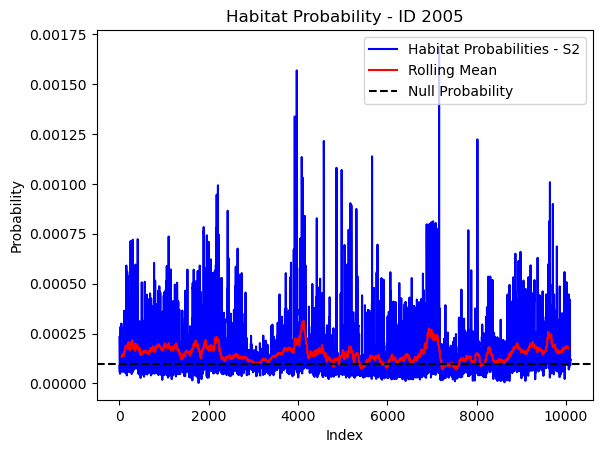

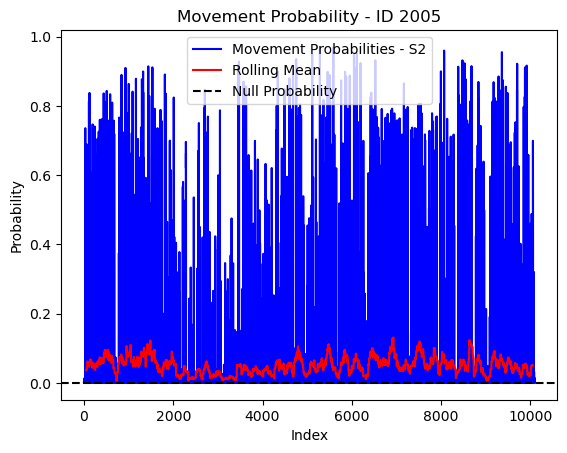

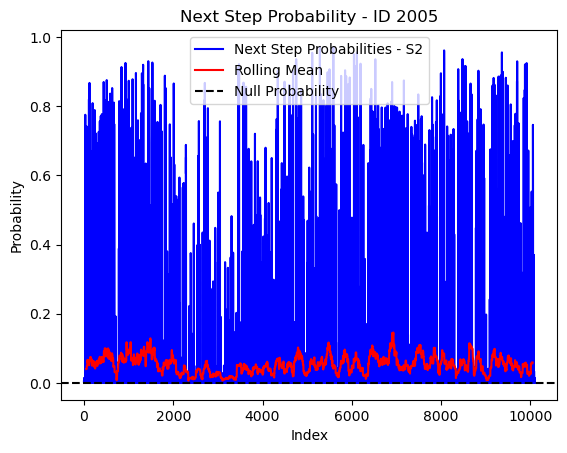

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2005_n10100_2025-02-13.csv


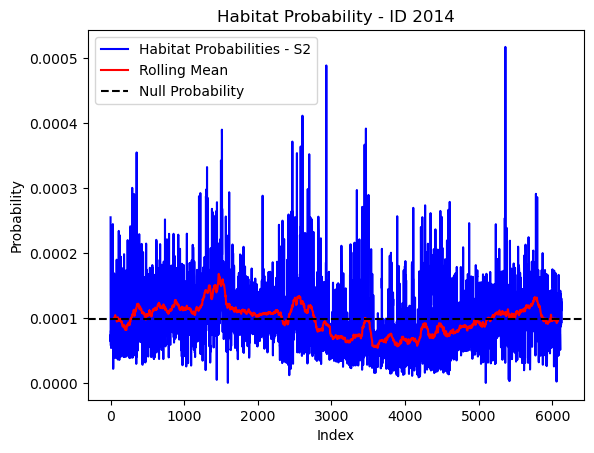

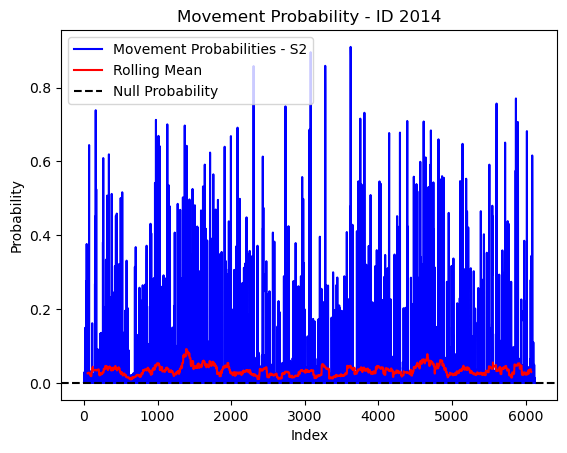

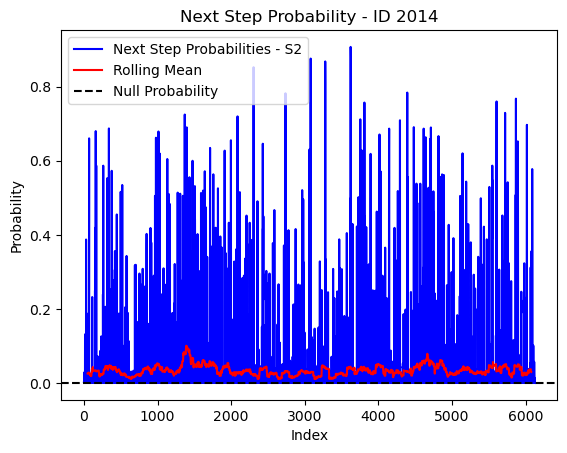

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2014_n6126_2025-02-13.csv


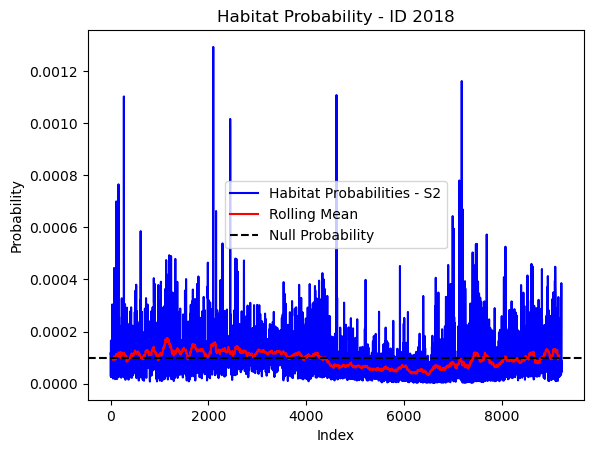

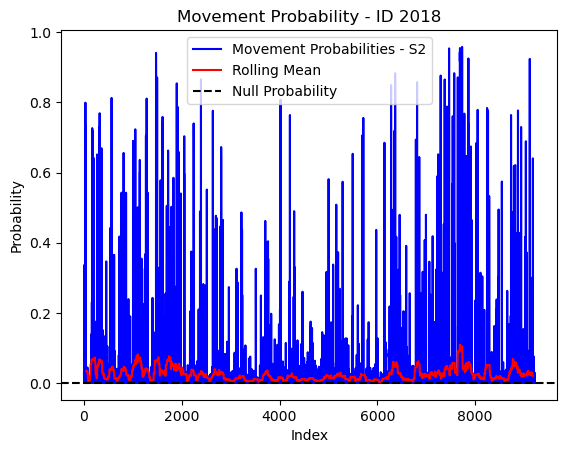

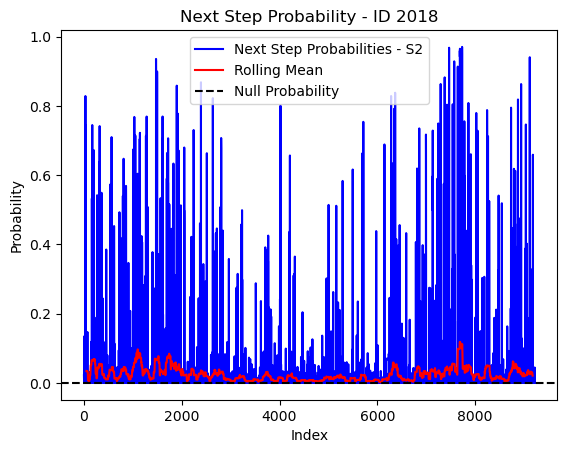

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2018_n9223_2025-02-13.csv


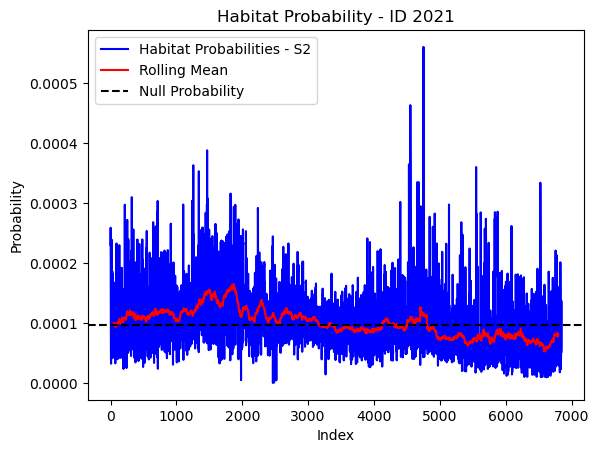

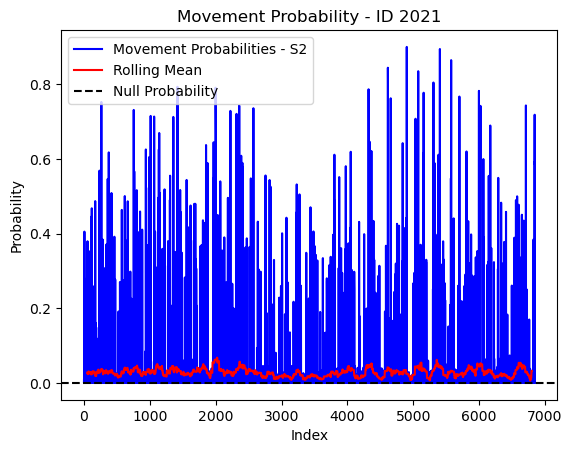

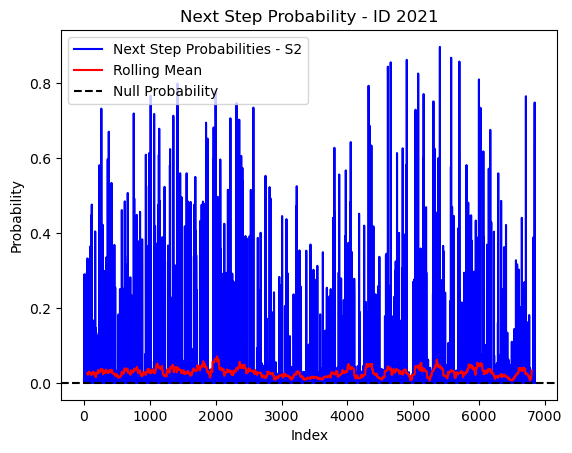

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2021_n6849_2025-02-13.csv


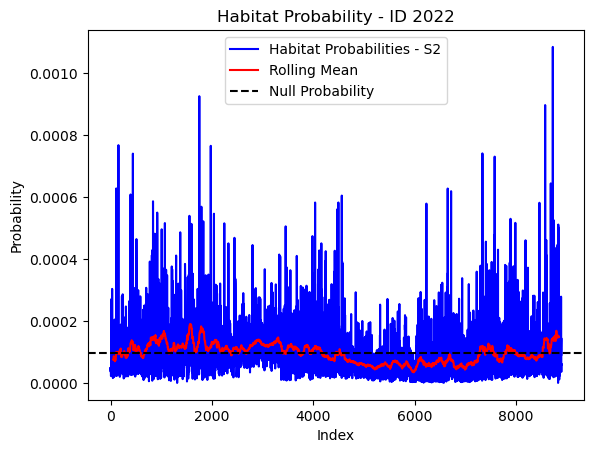

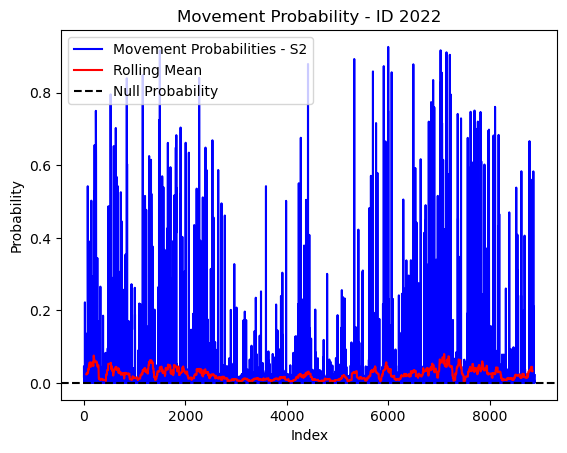

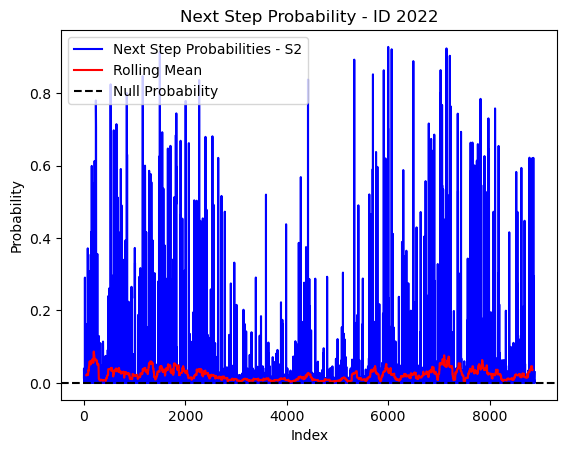

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2022_n8895_2025-02-13.csv


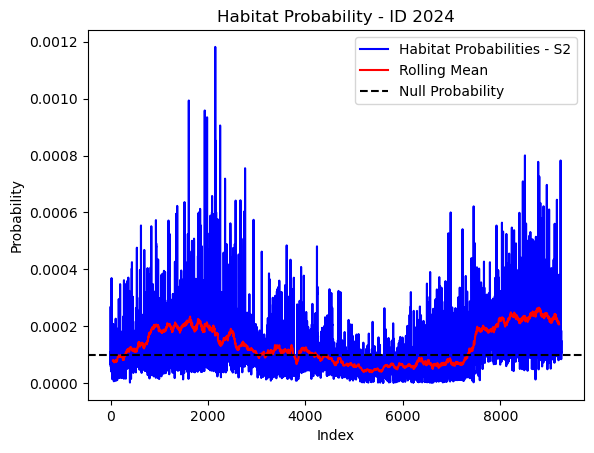

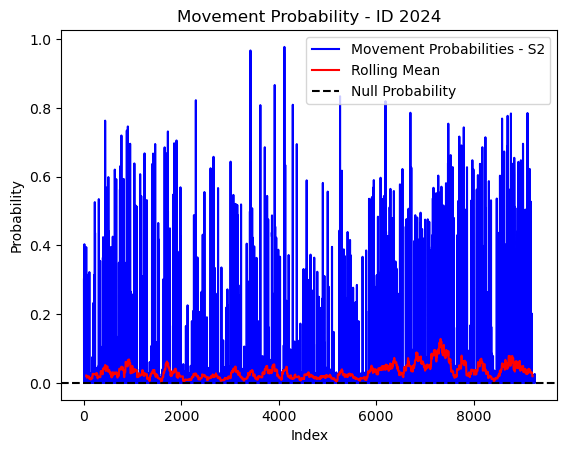

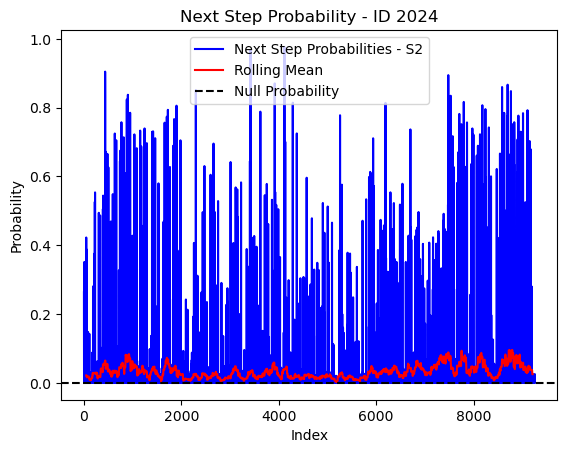

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2024_n9258_2025-02-13.csv


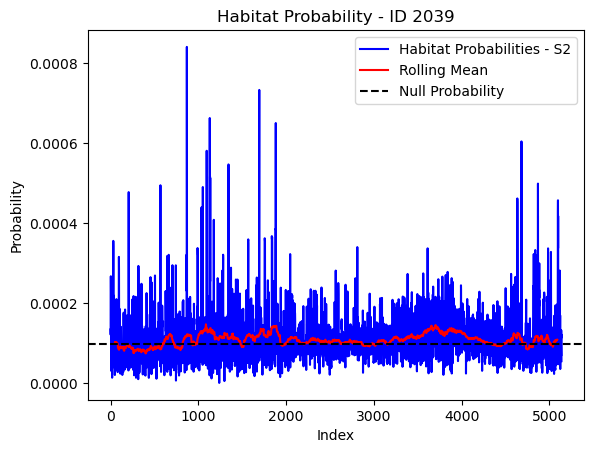

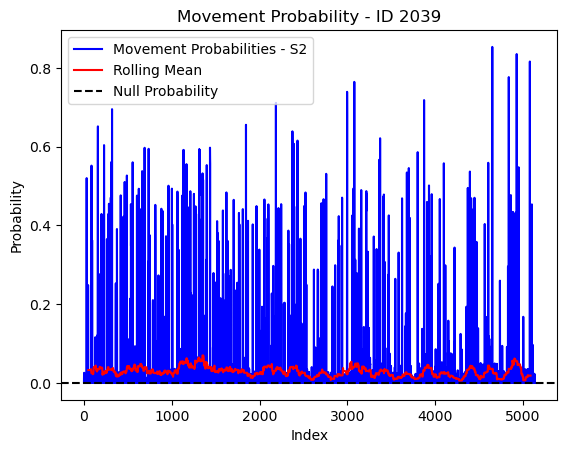

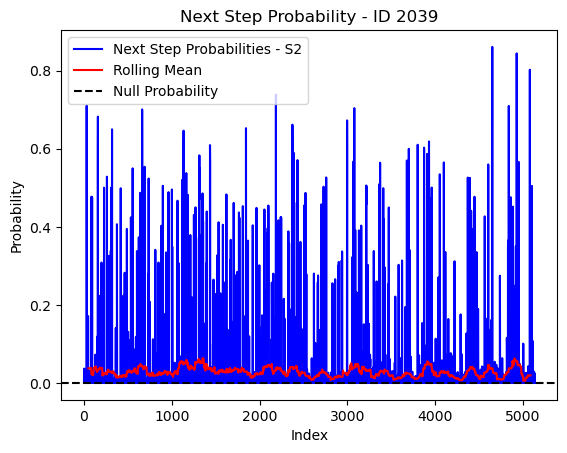

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2039_n5139_2025-02-13.csv


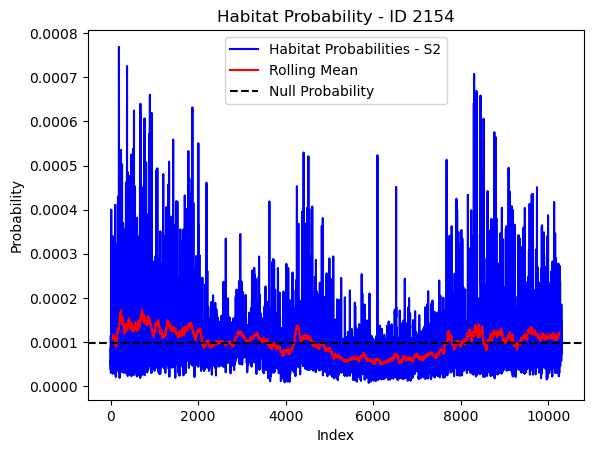

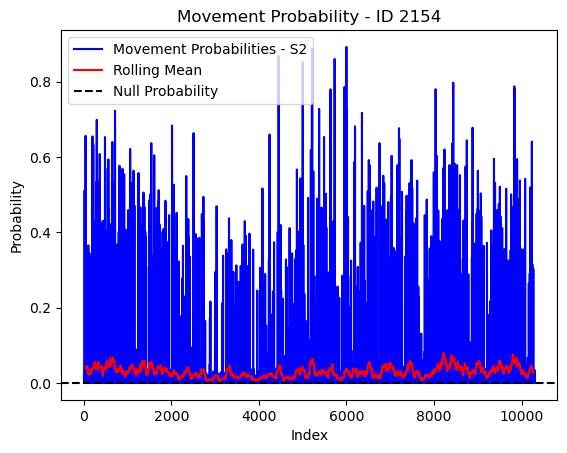

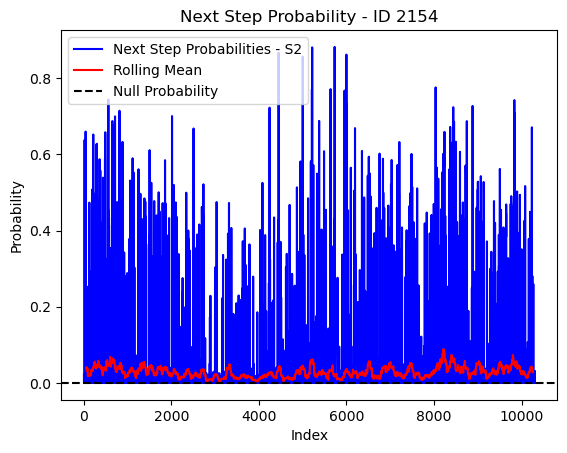

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2154_n10307_2025-02-13.csv


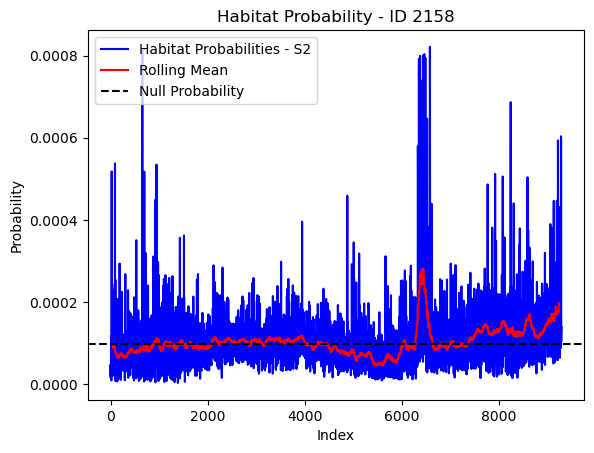

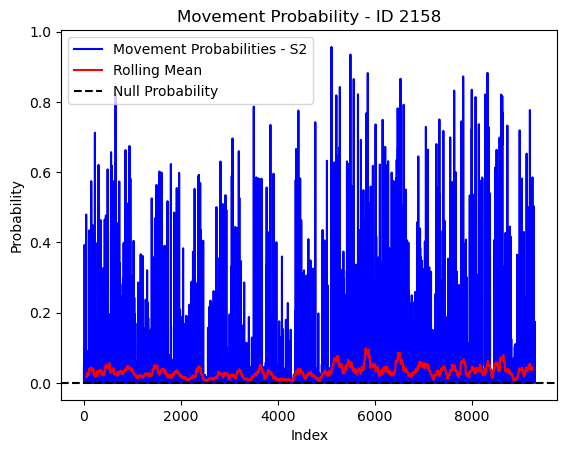

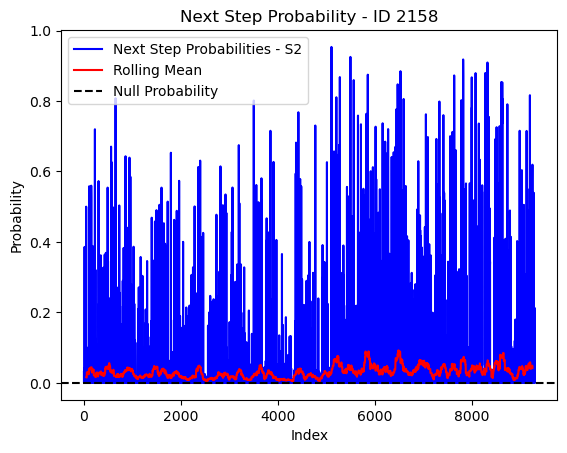

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2158_n9297_2025-02-13.csv


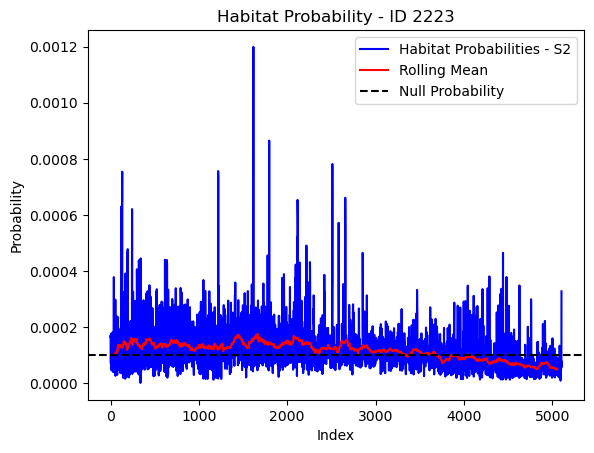

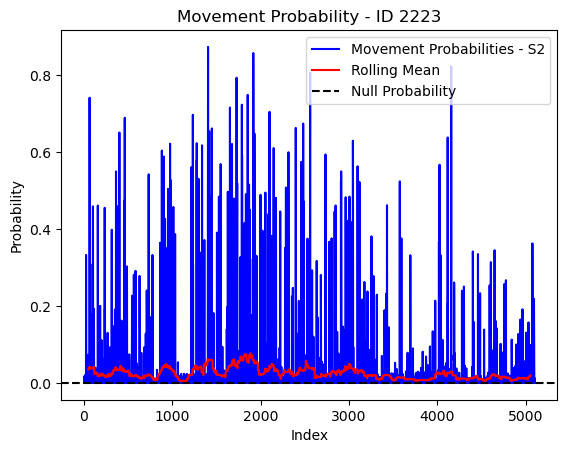

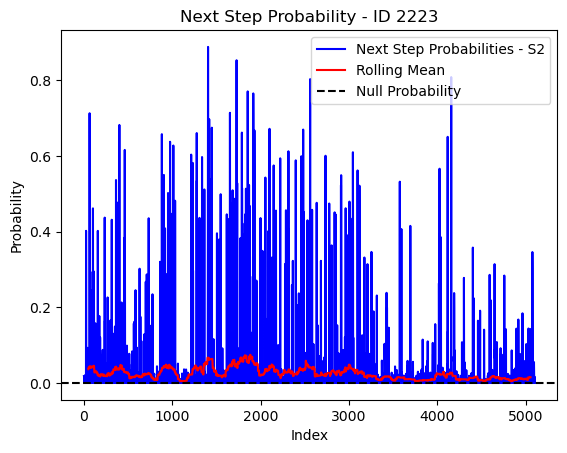

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2223_n5107_2025-02-13.csv


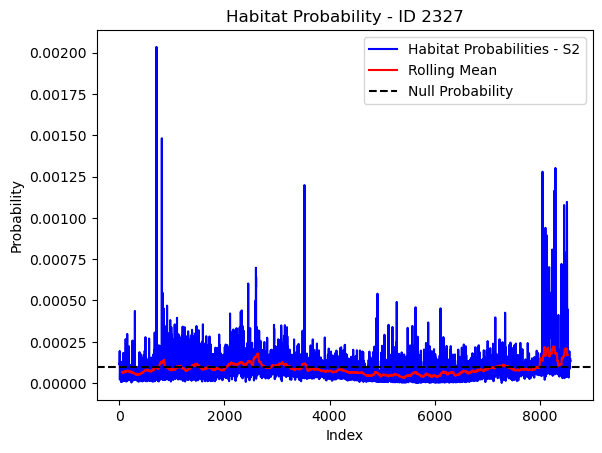

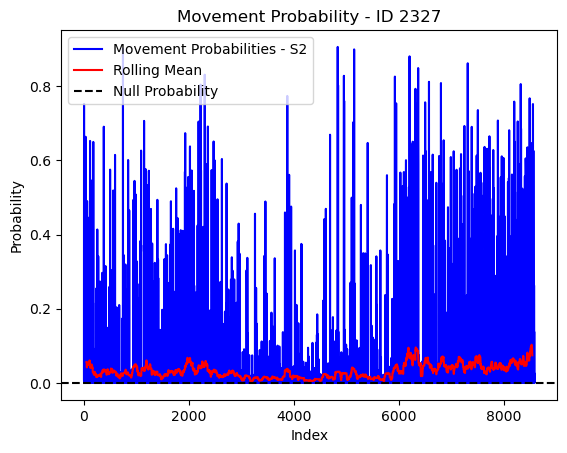

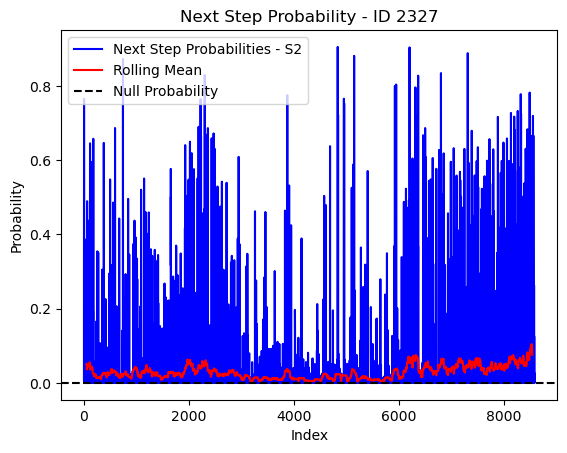

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2327_n8588_2025-02-13.csv


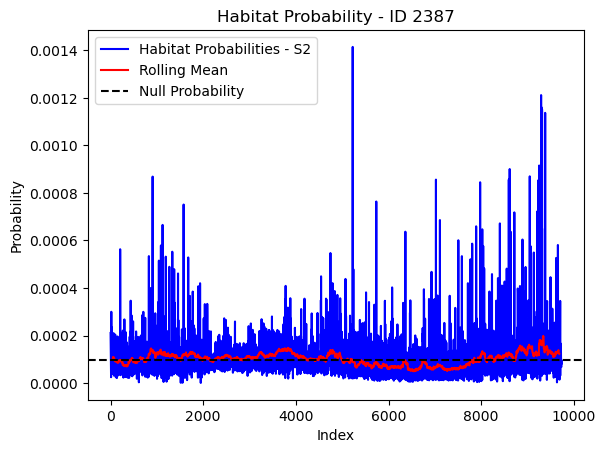

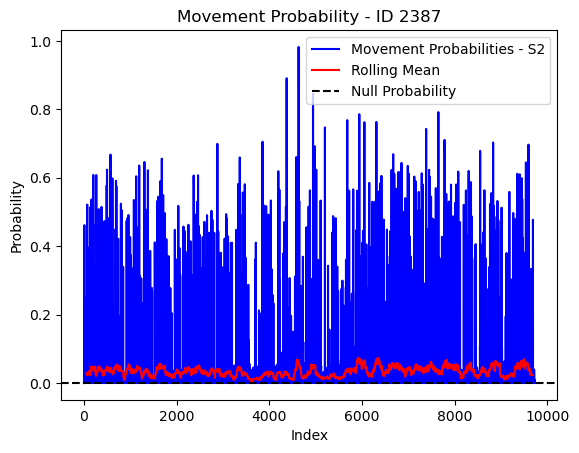

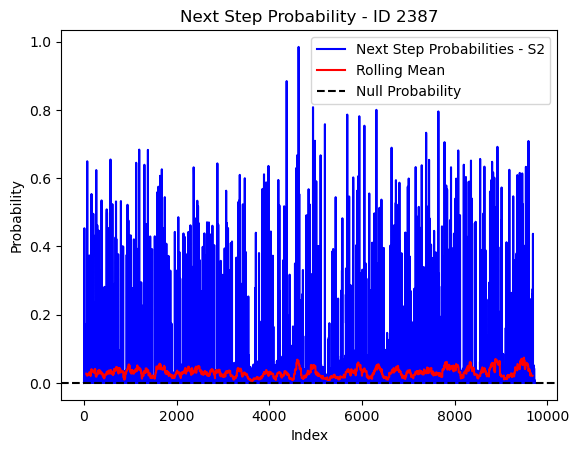

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2387_n9736_2025-02-13.csv


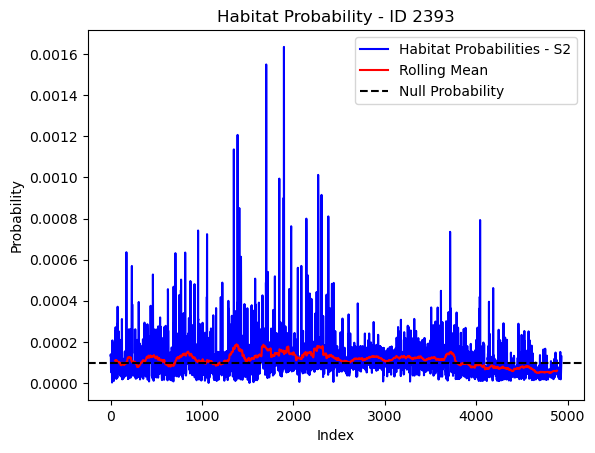

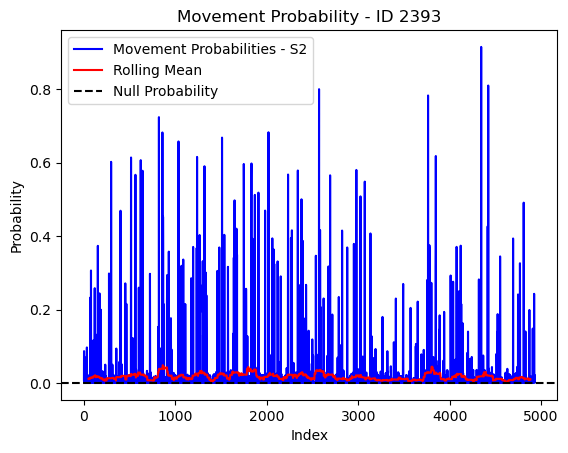

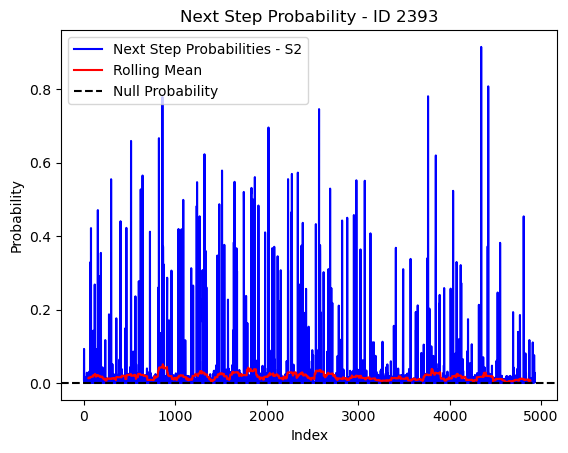

File saved as:     ../outputs/next_step_validation/S2/deepSSF_id2393_n4933_2025-02-13.csv


In [39]:
for j in range(0, len(csv_files)):

    # Read one of the CSV files into a DataFrame
    buffalo_df = pd.read_csv(csv_files[j])

    # Extract ID from the string for saving the file
    buffalo_id = csv_files[j][55:59]

    # Lag the bearing values in column 'A' by one index (to get the previous bearing)
    buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
    # Pad the missing value with a specified value, e.g., 0
    buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

    test_data = buffalo_df
    n_samples = len(test_data)

    # create empty vectors to store the predicted probabilities
    habitat_probs = np.repeat(0., n_samples)
    move_probs = np.repeat(0., n_samples)
    next_step_probs = np.repeat(0., n_samples)

    # start at 1 so the bearing at t - 1 is available
    for i in range(1, n_samples):
    
        sample = test_data.iloc[i]

        # Current location (x1, y1)
        x = sample['x1_']
        y = sample['y1_']

        # Convert geographic coordinates to pixel coordinates
        px, py = ~raster_transform * (x, y)

        # Next step location (x2, y2)
        x2 = sample['x2_']
        y2 = sample['y2_']

        # Convert geographic coordinates to pixel coordinates
        px2, py2 = ~raster_transform * (x2, y2)

        # The difference in x and y coordinates
        d_x = x2 - x
        d_y = y2 - y
        # print('d_x and d_y are ', d_x, d_y) # Debugging
        
        # Temporal covariates
        hour_t2_sin = sample['hour_t2_sin']
        hour_t2_cos = sample['hour_t2_cos']
        yday_t2_sin = sample['yday_t2_sin']
        yday_t2_cos = sample['yday_t2_cos']

        # Bearing of previous step (t - 1)
        bearing = sample['bearing_tm1']

        # Day of the year
        yday = sample['yday_t2']

        # Convert day of the year to month index
        month_index = day_to_month_index(yday)
        # print(month_index)

        # Adjust month_index to range from 1 to 12
        month_index = (month_index - 1) % 12 + 1

        # for sentinel 2 data
        selected_month = f'2019_{month_index:02d}'
        # Get the normalized data for the selected month
        s2_data = data_dict[selected_month]

        # Convert the NumPy array to a PyTorch tensor
        s2_tensor = torch.from_numpy(s2_data)
        s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
        # print(s2_tensor.shape)

        # Get the subset of the Sentinel-2 bands
        s2_b1_subset, origin_x, origin_y = subset_function(s2_tensor[0,:,:], x, y, window_size, raster_transform)
        s2_b2_subset, origin_x, origin_y = subset_function(s2_tensor[1,:,:], x, y, window_size, raster_transform)
        s2_b3_subset, origin_x, origin_y = subset_function(s2_tensor[2,:,:], x, y, window_size, raster_transform)
        s2_b4_subset, origin_x, origin_y = subset_function(s2_tensor[3,:,:], x, y, window_size, raster_transform)
        s2_b5_subset, origin_x, origin_y = subset_function(s2_tensor[4,:,:], x, y, window_size, raster_transform)
        s2_b6_subset, origin_x, origin_y = subset_function(s2_tensor[5,:,:], x, y, window_size, raster_transform)
        s2_b7_subset, origin_x, origin_y = subset_function(s2_tensor[6,:,:], x, y, window_size, raster_transform)
        s2_b8_subset, origin_x, origin_y = subset_function(s2_tensor[7,:,:], x, y, window_size, raster_transform)
        s2_b8a_subset, origin_x, origin_y = subset_function(s2_tensor[8,:,:], x, y, window_size, raster_transform)
        s2_b9_subset, origin_x, origin_y = subset_function(s2_tensor[9,:,:], x, y, window_size, raster_transform)
        s2_b11_subset, origin_x, origin_y = subset_function(s2_tensor[10,:,:], x, y, window_size, raster_transform)
        s2_b12_subset, origin_x, origin_y = subset_function(s2_tensor[11,:,:], x, y, window_size, raster_transform)

        # Get the subset of the slope landscape
        slope_subset, origin_x, origin_y = subset_function(slope_landscape_norm, x, y, window_size, raster_transform)

        # Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
        x1 = torch.stack([s2_b1_subset,
                            s2_b2_subset, 
                            s2_b3_subset, 
                            s2_b4_subset, 
                            s2_b5_subset,
                            s2_b6_subset,
                            s2_b7_subset,
                            s2_b8_subset,
                            s2_b8a_subset,
                            s2_b9_subset,
                            s2_b11_subset,
                            s2_b12_subset,
                            slope_subset], dim=0)
        
        x1 = x1.unsqueeze(0)
        # print(x1.shape)

        # print('origin_x and origin_y are ', origin_x, origin_y)

        px2_subset = px2 - origin_x
        py2_subset = py2 - origin_y
        # print('delta origin_x and origin_y are ', px2_subset, py2_subset)
        # print('delta origin_x and origin_y are ', int(px2_subset), int(py2_subset))

        # Convert lists to PyTorch tensors
        hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
        hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
        yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
        yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()

        # Stack tensors column-wise
        x2 = torch.stack((hour_t2_sin_tensor.unsqueeze(0), 
                            hour_t2_cos_tensor.unsqueeze(0), 
                            yday_t2_sin_tensor.unsqueeze(0), 
                            yday_t2_cos_tensor.unsqueeze(0)),  
                            dim=1)
        # print(x2)
        # print(x2.shape)

        # put bearing in the correct dimension (batch_size, 1)
        bearing = torch.tensor(bearing).float().unsqueeze(0).unsqueeze(0)
        # print(bearing)
        # print(bearing.shape)

        # -------------------------------------------------------------------------
        # Run the model
        # -------------------------------------------------------------------------
        model_output = model((x1, x2, bearing))


        # -------------------------------------------------------------------------
        # Habitat selection probability
        # -------------------------------------------------------------------------
        hab_density = model_output.detach().cpu().numpy()[0,:,:,0]
        hab_density_exp = np.exp(hab_density)
        # print(np.sum(hab_density_exp)) # Should be 1

        # Store the probability of habitat selection at the location of x2, y2
        # These probabilities are normalised in the model function
        habitat_probs[i] = hab_density_exp[(int(py2_subset), int(px2_subset))]
        # print('Habitat probability value = ', habitat_probs[i])


        # -------------------------------------------------------------------------
        # Movement probability
        # -------------------------------------------------------------------------
        move_density = model_output.detach().cpu().numpy()[0,:,:,1]
        move_density_exp = np.exp(move_density)
        # print(np.sum(move_density_exp))  # Should be 1

        # Store the movement probability at the location of x2, y2
        # These probabilities are normalised in the model function
        move_probs[i] = move_density_exp[(int(py2_subset), int(px2_subset))]
        # print('Movement probability value = ', move_probs[i])


        # -------------------------------------------------------------------------
        # Next step probability
        # -------------------------------------------------------------------------
        step_density = hab_density + move_density
        step_density_exp = np.exp(step_density)
        # print('Sum of step density exp = ', np.sum(step_density_exp)) # Won't be 1

        step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
        # print('Sum of step density exp norm = ', np.sum(step_density_exp_norm)) # Should be 1

        # Extract the value of the covariates at the location of x2, y2
        next_step_probs[i] = step_density_exp_norm[(int(py2_subset), int(px2_subset))]
        # print('Next-step probability value = ', next_step_probs[i])


    # Convert to pandas Series and compute rolling mean
    rolling_mean_habitat = pd.Series(habitat_probs).rolling(window=window_size, center=True).mean()
    rolling_mean_movement = pd.Series(move_probs).rolling(window=window_size, center=True).mean()
    rolling_mean_next_step = pd.Series(next_step_probs).rolling(window=window_size, center=True).mean()

    # Plot the habitat probs through time as a line graph
    plt.plot(habitat_probs[habitat_probs > 0], color='blue', label='Habitat Probabilities - S2')
    plt.plot(rolling_mean_habitat[rolling_mean_habitat > 0], color='red', label='Rolling Mean')
    plt.axhline(y=null_prob, color='black', linestyle='--', label='Null Probability')  # null probs
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.title(f'Habitat Probability - ID {buffalo_id}')
    plt.legend()  # Add legend to differentiate lines
    plt.show()

    # Plot the movement probs through time as a line graph
    plt.plot(move_probs[move_probs > 0], color='blue', label='Movement Probabilities - S2')
    plt.plot(rolling_mean_movement[rolling_mean_movement > 0], color='red', label='Rolling Mean')
    plt.axhline(y=null_prob, color='black', linestyle='--', label='Null Probability')  # null probs
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.title(f'Movement Probability - ID {buffalo_id}')
    plt.legend()  # Add legend to differentiate lines
    plt.show()

    # Plot the next step probs through time as a line graph
    plt.plot(next_step_probs[next_step_probs > 0], color='blue', label='Next Step Probabilities - S2')
    plt.plot(rolling_mean_next_step[rolling_mean_next_step > 0], color='red', label='Rolling Mean')
    plt.axhline(y=null_prob, color='black', linestyle='--', label='Null Probability')  # null probs
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.title(f'Next Step Probability - ID {buffalo_id}')
    plt.legend()  # Add legend to differentiate lines
    plt.show()

    # Save the data to a CSV file
    csv_filename = f'{output_dir}/deepSSF_id{buffalo_id}_n{len(test_data)}_{today_date}.csv'
    print(f'File saved as:     {csv_filename}')
    buffalo_df.to_csv(csv_filename, index=True)

In [64]:
buffalo_df

x_            y_                    t_    id           x1_  \
0     32550.348534 -1.423005e+06  2018-07-25T02:11:31Z  2393  32550.348534   
1     32550.671636 -1.423009e+06  2018-07-25T03:10:28Z  2393  32550.671636   
2     32549.540847 -1.423008e+06  2018-07-25T04:11:04Z  2393  32549.540847   
3     32552.107877 -1.423003e+06  2018-07-25T05:12:01Z  2393  32552.107877   
4     32555.777954 -1.423001e+06  2018-07-25T06:10:49Z  2393  32555.777954   
...            ...           ...                   ...   ...           ...   
4928  28787.834376 -1.424392e+06  2019-03-27T16:00:32Z  2393  28787.834376   
4929  28777.782281 -1.424457e+06  2019-03-27T17:01:31Z  2393  28777.782281   
4930  28716.577830 -1.424413e+06  2019-03-27T18:01:19Z  2393  28716.577830   
4931  28714.836029 -1.424412e+06  2019-03-27T19:00:46Z  2393  28714.836029   
4932  28712.673595 -1.424411e+06  2019-03-27T20:00:32Z  2393  28712.673595   

               y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0    -1.423005e+06  32550.671636 -1.423009e+06    0.323102  -4.336324  ...   
1    -1.423009e+06  32549.540847 -1.423008e+06   -1.130789   0.917171  ...   
2    -1.423008e+06  32552.107877 -1.423003e+06    2.567030   5.311862  ...   
3    -1.423003e+06  32555.777954 -1.423001e+06    3.670077   2.023739  ...   
4    -1.423001e+06  32550.932926 -1.422997e+06   -4.845028   3.771053  ...   
...            ...           ...           ...         ...        ...  ...   
4928 -1.424392e+06  28777.782281 -1.424457e+06  -10.052095 -65.189917  ...   
4929 -1.424457e+06  28716.577830 -1.424413e+06  -61.204452  43.456804  ...   
4930 -1.424413e+06  28714.836029 -1.424412e+06   -1.741801   0.895489  ...   
4931 -1.424412e+06  28712.673595 -1.424411e+06   -2.162434   1.573750  ...   
4932 -1.424411e+06  28860.395066 -1.424357e+06  147.721471  53.920949  ...   

             x_max         y_min         y_max  ndvi_index  year_t2  \
0     33812.848534 -1.424267e+06 -1.421742e+06           8     2018   
1     33813.171636 -1.424272e+06 -1.421747e+06           8     2018   
2     33812.040847 -1.424271e+06 -1.421746e+06           8     2018   
3     33814.607877 -1.424266e+06 -1.421741e+06           8     2018   
4     33818.277954 -1.424264e+06 -1.421739e+06           8     2018   
...            ...           ...           ...         ...      ...   
4928  30050.334376 -1.425654e+06 -1.423129e+06          16     2019   
4929  30040.282281 -1.425719e+06 -1.423194e+06          16     2019   
4930  29979.077830 -1.425676e+06 -1.423151e+06          16     2019   
4931  29977.336029 -1.425675e+06 -1.423150e+06          16     2019   
4932  29975.173595 -1.425673e+06 -1.423148e+06          16     2019   

      yday_t2_2018_base  bearing_tm1  habitat_probs  move_probs  \
0                   206     0.000000       0.000000    0.000000   
1                   206    -1.496423       0.000090    0.017356   
2                   206     2.460126       0.000096    0.020171   
3                   206     1.120627       0.000096    0.088415   
4                   206     0.503930       0.000100    0.011493   
...                 ...          ...            ...         ...   
4928                452     1.614742       0.000027    0.002081   
4929                452    -1.723788       0.000061    0.001257   
4930                452     2.524169       0.000068    0.090440   
4931                452     2.666716       0.000070    0.044450   
4932                452     2.512473       0.000108    0.000570   

      next_step_probs  
0            0.000000  
1            0.015585  
2            0.019478  
3            0.082264  
4            0.010830  
...               ...  
4928         0.000713  
4929         0.000586  
4930         0.046953  
4931         0.022507  
4932         0.000488  

[4933 rows x 38 columns]